In [5]:
import torch  # Main torch import for torch tensors
import torch.nn as nn  # Neural network module for building deep learning models
import torch.nn.functional as F  # Functional module, includes activation functions
import torch.optim as optim  # Optimization module
import torchvision  # Vision / image processing package built on top of torch
import typing
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt  # Plotting and visualization
from sklearn.metrics import accuracy_score  # Computing accuracy metric

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

In [ ]:
def load_data() -> typing.Tuple[DataLoader, DataLoader]:
    # Any data augmentation should be added to training
    train_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=0.1307, std=0.3081)
    ])

    # Test data should have normalization applied, but no augmentation
    test_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=0.1307, std=0.3081)
    ])

    # Download the MNIST data and lazily apply the transformation pipeline
    train_data = torchvision.datasets.MNIST('./datafiles/', train=True, download=True, transform=train_transform)
    test_data = torchvision.datasets.MNIST('./datafiles/', train=False, download=True, transform=test_transform)

    # Setup data loaders
    # Note: Iterating through the dataloader yields batches of (inputs, targets)
    # where inputs is a torch.Tensor of shape (B, 1, 28, 28) and targets is a torch.Tensor of shape (B,)
    BATCH_SIZE = 512
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000)
    return train_loader, test_loader

def visualize_batch(data_loader: DataLoader) -> None:
    # Plot examples of transformations
    fig, axs = plt.subplots(4, 5, figsize=(5, 6))

    plot_images = []
    plot_labels = []

    for images, labels in data_loader:
        for i in range(images.shape[0]):
            plot_images.append(images[i])
            plot_labels.append(labels[i])
            if len(plot_images) >= 20:
                break
        if len(plot_images) >= 20:
            break
    
    for i in range(4):
        for j in range(5):
            axs[i, j].imshow(plot_images[i * 5 + j].squeeze(), cmap='gray')
            axs[i, j].set_title(f"Label: {plot_labels[i * 5 + j].item()}")
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()
    plt.close()
    return
def train(model, train_loader, loss_fn, optimizer, epoch=-1):
    """
    Trains a model for one epoch (one pass through the entire training data).

    :param model: PyTorch model
    :param train_loader: PyTorch Dataloader for training data
    :param loss_fn: PyTorch loss function
    :param optimizer: PyTorch optimizer, initialized with model parameters
    :kwarg epoch: Integer epoch to use when printing loss and accuracy
    :returns: Accuracy score
    """
    total_loss = 0
    all_predictions = []
    all_targets = []
    loss_history = []

    model = model.to(DEVICE)
    model.train()  # Set model in training mode

    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets.to(DEVICE))
        loss.backward()
        optimizer.step()

        # Track some values to compute statistics
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=-1)
        all_predictions.extend(preds.detach().cpu().tolist())
        all_targets.extend(targets.cpu().tolist())

        # Save loss every 100 batches
        if (i % 100 == 0) and (i > 0):
            running_loss = total_loss / (i + 1)
            loss_history.append(running_loss)
            # print(f"Epoch {epoch + 1}, batch {i + 1}: loss = {running_loss:.2f}")

    acc = accuracy_score(all_targets, all_predictions)
    final_loss = total_loss / len(train_loader)
    # Print average loss and accuracy
    print(f"Epoch {epoch + 1} done. Average train loss = {final_loss:.2f}, average train accuracy = {acc * 100:.3f}%")
    return acc, final_loss

def test(model, test_loader, loss_fn, epoch=-1):
    """
    Tests a model for one epoch of test data.

    Note:
        In testing and evaluation, we do not perform gradient descent optimization, so steps 2, 5, and 6 are not needed.
        For performance, we also tell torch not to track gradients by using the `with torch.no_grad()` context.

    :param model: PyTorch model
    :param test_loader: PyTorch Dataloader for test data
    :param loss_fn: PyTorch loss function
    :kwarg epoch: Integer epoch to use when printing loss and accuracy

    :returns: Accuracy score
    """
    total_loss = 0
    all_predictions = []
    all_targets = []

    model = model.to(DEVICE)
    model.eval()  # Set model in evaluation mode
    for i, (inputs, targets) in enumerate(test_loader):
        with torch.no_grad():
            outputs = model(inputs.to(DEVICE))
            loss = loss_fn(outputs, targets.to(DEVICE))

            # Track some values to compute statistics
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=-1)
            all_predictions.extend(preds.detach().cpu().tolist())
            all_targets.extend(targets.cpu().tolist())

    acc = accuracy_score(all_targets, all_predictions)
    final_loss = total_loss / len(test_loader)
    # Print average loss and accuracy
    print(f"Epoch {epoch + 1} done. Average test loss = {final_loss:.2f}, average test accuracy = {acc * 100:.3f}%")
    return acc, final_loss


train_loader, test_loader = load_data()

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BaselineConvNet(nn.Module):
    def __init__(self):
        super(BaselineConvNet, self).__init__()

        # Convolutional layers with stride for downsampling
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)

        # Fully connected layers
        dim = 28 * 28 * 16
        self.fc1 = nn.Linear(28 * 28 * 16, 10)

    def forward(self, x):
        # First conv block
        x = F.relu(self.conv1(x))   # (batch, 16, 28, 28)
        
        # Flatten
        x = x.view(x.size(0), -1)   # (batch, 1568)
        
        # Fully connected layers
        x = self.fc1(x)

        return x


In [ ]:
model = BaseException()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def training_loop(num_epochs=10, learning_rate=0.001, show_plots=True):
    train_accuracies = []
    test_accuracies = []
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        train_acc, train_loss = train(model, train_loader, loss_fn, optimizer, epoch)
        test_acc, test_loss = test(model, test_loader, loss_fn, epoch)

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

    if not show_plots:
        return

    # Plot accuracies
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
    axs[0].plot(range(1, num_epochs + 1), test_accuracies, label="Test Accuracy")
    axs[0].set_title("Accuracy over Epochs")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()

    # Plot losses
    axs[1].plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
    axs[1].plot(range(1, num_epochs + 1), test_losses, label="Test Loss")
    axs[1].set_title("Loss over Epochs")
    axs[1].set_ylabel("Loss")
    axs[1].legend()

Epoch 1 done. Average train loss = 0.02, average train accuracy = 99.512%
Epoch 1 done. Average test loss = 0.07, average test accuracy = 97.950%
Epoch 2 done. Average train loss = 0.02, average train accuracy = 99.617%
Epoch 2 done. Average test loss = 0.07, average test accuracy = 97.930%
Epoch 3 done. Average train loss = 0.01, average train accuracy = 99.662%
Epoch 3 done. Average test loss = 0.08, average test accuracy = 97.720%
Epoch 4 done. Average train loss = 0.01, average train accuracy = 99.675%
Epoch 4 done. Average test loss = 0.07, average test accuracy = 97.970%
Epoch 5 done. Average train loss = 0.01, average train accuracy = 99.745%
Epoch 5 done. Average test loss = 0.07, average test accuracy = 97.890%


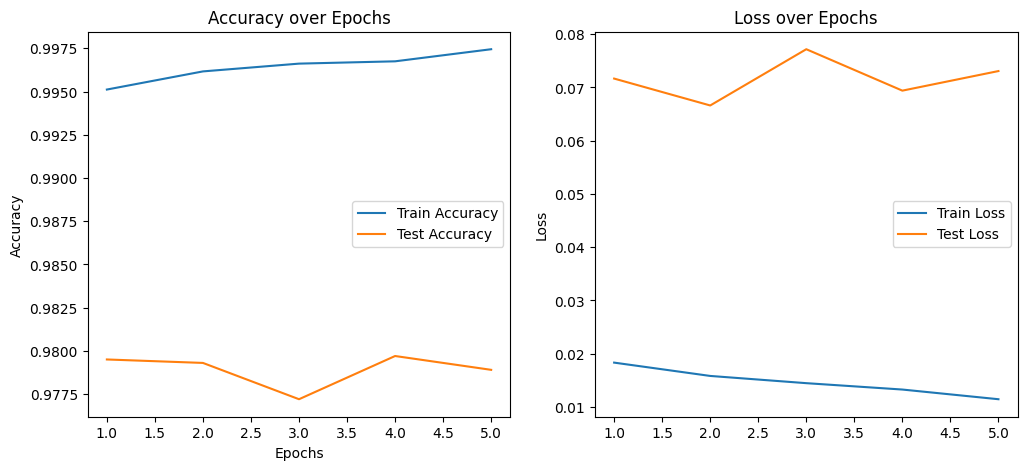

In [31]:
training_loop(num_epochs=5, learning_rate=0.001, show_plots=True)